In [78]:
!pip install KoNLPy

## 데이터 로드와 정제

In [80]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7ff95df3e588>)

In [27]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')
print('훈련용 리뷰 개수 :',len(train_data))
print('테스트용 리뷰 개수 :',len(test_data))

훈련용 리뷰 개수 : 150000
테스트용 리뷰 개수 : 50000


In [28]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [29]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [30]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [31]:
train_data.drop_duplicates(subset=['document'], inplace=True) #document 열에서 중복인 내용이 있다면 중복 제거

In [32]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


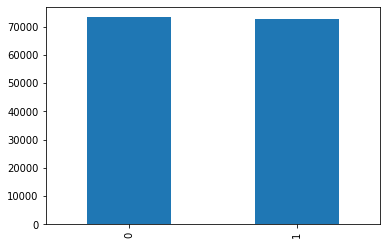

In [33]:
train_data['label'].value_counts().plot(kind = 'bar')

In [34]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [35]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [36]:
train_data = train_data.dropna(how='any')
print(train_data.isnull().sum())

id          0
document    0
label       0
dtype: int64


In [37]:
print(len(train_data))

146182


In [38]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") #한글과 공백을 제외하고 모두 제거
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [39]:
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    391
label         0
dtype: int64


In [40]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145791


In [41]:
test_data.drop_duplicates(subset = ['document'], inplace=True) #document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") #정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) #공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') #Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48995


## 토큰화

In [42]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [43]:
okt = Okt() #Konlpy
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [44]:
X_train = []
for sentence in train_data['document']:
  temp_X = []
  temp_X = okt.morphs(sentence, stem=True) #토큰화
  temp_X = [word for word in temp_X if not word in stopwords] #불용어 제거
  X_train.append(temp_X)

In [45]:
print(X_train[:5])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'], ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'], ['사이', '몬페', '그', '익살스럽다', '연기', '돋보이다', '영화', '스파이더맨', '에서', '늙다', '보이다', '커스틴', '던스트', '너무나도', '이쁘다', '보이다']]


In [46]:
X_test = []
for sentence in test_data['document']:
  temp_X = []
  temp_X = okt.morphs(sentence, stem=True) #토큰화
  temp_X = [word for word in temp_X if not word in stopwords] #불용어 제거
  X_test.append(temp_X)

## 정수 인코딩

In [47]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [49]:
threshold = 3
total_cnt = len(tokenizer.word_index) #단어의 수
rare_cnt = 0 #등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 #훈련 데이터의 전체 단어 빈도수 총합
rare_freq = 0 #등장 빈도수가 threshold보다 작은 단어의 등장 빈도수 총합

#단어와 빈도수의 쌍을 key와 value로 받는다
for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value

  #단어의 등장 빈도수가 threshold보다 작으면
  if(value < threshold):
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print("단어 집합의 크기 : ", total_cnt)
print("등장 빈도가 %s번 이하인 희귀 단어의 수 : %s" %(threshold-1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율 : ", (rare_cnt/total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 비도의 비율 : ", (rare_freq/total_freq)*100)

단어 집합의 크기 :  43752
등장 빈도가 2번 이하인 희귀 단어의 수 : 24337
단어 집합에서 희귀 단어의 비율 :  55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 비도의 비율 :  1.8715872104872904


In [50]:
#전체 단어 개수 중 빈도수 2 이하인 단어 개수는 제거
#0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2 
vocab_size = total_cnt - rare_cnt + 2
print("단어 집합의 크기 : ", vocab_size)

단어 집합의 크기 :  19417


In [51]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [52]:
print(X_train[:3])

[[51, 455, 17, 261, 660], [934, 458, 42, 603, 2, 215, 1450, 25, 962, 676, 20], [387, 2445, 1, 2316, 5672, 3, 223, 10]]


In [53]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

## 빈 샘플 제거

In [54]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [55]:
#빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145380
145380


## 패딩

리뷰의 최대 길이 :  72
리뷰의 평균 길이 :  11.002187371027652


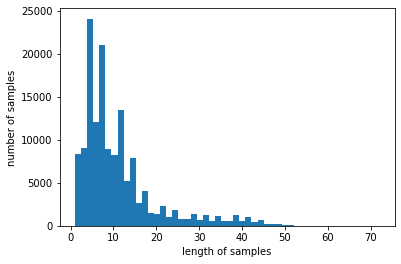

In [56]:
print("리뷰의 최대 길이 : ",max(len(i) for i in X_train))
print("리뷰의 평균 길이 : ", sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [57]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
      cnt = cnt+1
  print("전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s" %(max_len, (cnt/len(nested_list))*100))

In [58]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 99.91126702434998


In [59]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

## LSTM으로 감성 분석

In [60]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [61]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [62]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [63]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1937/1939 [============================>.] - ETA: 0s - loss: 0.3914 - acc: 0.8217
Epoch 00001: val_acc improved from -inf to 0.84685, saving model to best_model.h5
1939/1939 [==============================] - 27s 14ms/step - loss: 0.3914 - acc: 0.8218 - val_loss: 0.3518 - val_acc: 0.8468
Epoch 2/15
1936/1939 [============================>.] - ETA: 0s - loss: 0.3263 - acc: 0.8578
Epoch 00002: val_acc improved from 0.84685 to 0.85345, saving model to best_model.h5
1939/1939 [==============================] - 27s 14ms/step - loss: 0.3263 - acc: 0.8579 - val_loss: 0.3483 - val_acc: 0.8535
Epoch 3/15
1938/1939 [============================>.] - ETA: 0s - loss: 0.3007 - acc: 0.8725
Epoch 00003: val_acc improved from 0.85345 to 0.86061, saving model to best_model.h5
1939/1939 [==============================] - 26s 13ms/step - loss: 0.3007 - acc: 0.8725 - val_loss: 0.3290 - val_acc: 0.8606
Epoch 4/15
1937/1939 [============================>.] - ETA: 0s - loss: 0.2813 - acc: 0.8832
E

In [64]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" %(loaded_model.evaluate(X_test, y_test)[1]))

1532/1532 [==============================] - 4s 3ms/step - loss: 0.3390 - acc: 0.8531

 테스트 정확도: 0.8531


## 리뷰 예측하기

In [65]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence]) #정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) #패딩
  score = float(loaded_model.predict(pad_new)) #예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [66]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')
sentiment_predict('감독 뭐하는 놈이냐?')
sentiment_predict('이 영화 핵노잼 ㅠㅠ')
sentiment_predict('이딴게 영화냐 ㅉㅉ')
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

89.47% 확률로 긍정 리뷰입니다.

97.37% 확률로 부정 리뷰입니다.

99.64% 확률로 부정 리뷰입니다.

99.82% 확률로 부정 리뷰입니다.

79.60% 확률로 긍정 리뷰입니다.



## Utilize

In [67]:
import pandas as pd
import numpy as np

df_bert = pd.read_csv("HMG_Sentiment_Analysis_BERT.csv", encoding="cp949")

In [68]:
df_bert.sample(10)

,Unnamed: 0,식당명,리뷰 문장,BERT_SCORE
185,185,상수 종로빈대떡JBD,학교에선 멀지만 상수 합정 주민이면 올만할 거리,1
1991,3171,롯데리아,19년 02월 08일금부로 치즈 멜팅 관련 메뉴얼 변경 되었습니다,0
2900,4661,홍복원,새우만두 양도 줄고,0
1179,1776,상수 버들골이야기,다른테이블 보니 탕메뉴나 육회연어2만원대도 많이먹는듯,0
2960,4749,염소자리음주요리,난 스테이크 일행은 사케동 시켰거든,0
2849,4581,상수 카이화,잡채밥6000,1
59,59,지로우라멘,양은 많은건 아니고 많이 먹는 사람은 좀 적을거 같아,0
3074,4935,노브랜드버거,마지막사진은 별버거임,0
2361,3750,짬뽕지존,ㅡ24시간,0
958,1385,깔롱커피,사장님 넘 친절하세요,1


In [88]:
df_bert.columns

Index(['Unnamed: 0', '식당명', '리뷰 문장', 'BERT_SCORE'], dtype='object')

In [89]:
del df_bert['Unnamed: 0']

In [90]:
df_bert.sample(5)

,식당명,리뷰 문장,BERT_SCORE
1988,롯데리아,더 멋있게 먹고싶더면 토마토토핑을 추가해먹어보셈,0
466,디이롱,연남 디이롱 이다 좐맛,1
640,신수정1971국물닭발,사진은 아쉽게도 없다,1
2422,스티브칩스,손님이한명도없어요,1
1272,수카츠,맛도 괜찮았어 바로 튀겨줘서 바삭하지만,1


In [92]:
df_bert.isnull().sum()

식당명           0
리뷰 문장         4
BERT_SCORE    0
dtype: int64

In [93]:
df_rnn = df_bert.dropna(axis=0)

In [94]:
sampling = df_rnn["리뷰 문장"][59]
print(sampling)
sentiment_predict(sampling)

양은 많은건 아니고 많이 먹는 사람은 좀 적을거 같아
64.54% 확률로 긍정 리뷰입니다.



In [85]:
def label_review(series_object):
    list_scores = []
    list_reviews = series_object.to_list()
    for item in list_reviews:
        item = okt.morphs(item, stem=True) # 토큰화
        item = [word for word in item if not word in stopwords] # 불용어 제거
        encoded = tokenizer.texts_to_sequences([item]) # 정수 인코딩
        pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
        score = float(loaded_model.predict(pad_new)) # 예측
        list_scores.append(score)
    return list_scores

In [95]:
df_rnn["RNN_SCORE"] = label_review(df_rnn["리뷰 문장"])
df_rnn.sample(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,식당명,리뷰 문장,BERT_SCORE,RNN_SCORE
647,혜윰인핑크,정확한 상호명은 혜윰인핑크 이고 신긱골목 봉교앞에 잇습니다,1,0.469894
2141,로쏘 피자,일단 메뉴가 조금 어려워서 주문하는데 시간이 좀 걸렸지만 피자를 금방금방 구워주셔서...,1,0.574142
2974,하우,맛 집에서 엄마가 해주는 밥상 느낌,1,0.301191
3209,플라워,여자 현금 16000이구 남자는 기억 안남,0,0.106420
1981,롯데리아,필자는 새우버거를 싫어하지만 뭐 베스트셀러니 일단 넣어줌,0,0.087377
1590,계주집,금욜밤에 친구랑 학교쪽 걷다가 어디갈까 고민하다가,0,0.288122
2136,홍대 우산,감튀는 그냥그랬는데 버거 식감이 독특하고 맛있어서 재방문 의사있음,1,0.503767
2807,더리터,원래 더리터라는 카페를좋아했음,1,0.737786
2013,손오공마라탕,손오공 마라탕 맨날 가다가 위생단속 걸린 이후에 학교앞에 다른 마라탕집도 많이 생겼...,0,0.070801
1408,상수 크레이지파이,애플파이 사진엔 없지만 예전에 포장해와서 집에서 먹었습니다 기본 애플파이 맛인데 계...,1,0.110521


In [96]:
df_rnn.to_csv(f"HMG_Sentiment_Analysis_BERT_RNN.csv",encoding="cp949", index=False)